In [1]:
#!pip install tsaug
#!pip install seaborn

2025-01-22 16:34:36.607166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 16:34:36.659918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737543876.750138   51715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737543876.773082   51715 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 16:34:36.834680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

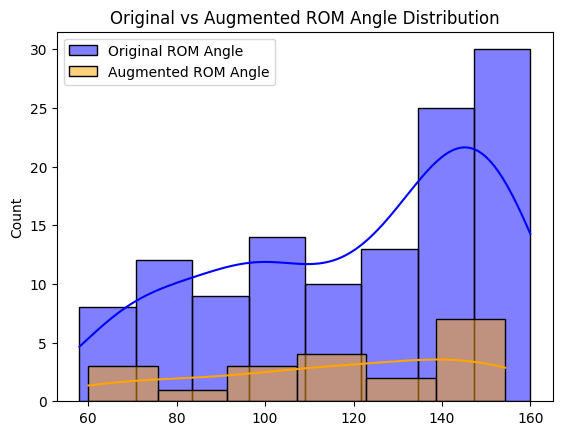

/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-22 16:34:53.737672: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 0.2268 - mae: 0.5995 - root_mean_squared_error: 0.6704 - val_loss: 0.2077 - val_mae: 0.6056 - val_root_mean_squared_error: 0.6420 - learning_rate: 0.0010
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1676 - mae: 0.5091 - root_mean_squared_error: 0.5756 - val_loss: 0.1241 - val_mae: 0.4622 - val_root_mean_squared_error: 0.4947 - learning_rate: 0.0010
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0963 - mae: 0.3760 - root_mean_squared_error: 0.4332 - val_loss: 0.0276 - val_mae: 0.1988 - val_root_mean_squared_error: 0.2271 - learning_rate: 0.0010
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0229 - mae: 0.1604 - root_mean_squared_error: 0.2046 - val_loss: 0.0334 - val_mae: 0.1893 - val_root_mean_squared_error: 0.2513 - learning_rate: 0.0010
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0240 - mae: 0.1487 - root_mean_squared_error: 0.2102 - val_loss: 0.0164 - val_mae: 0.1155 

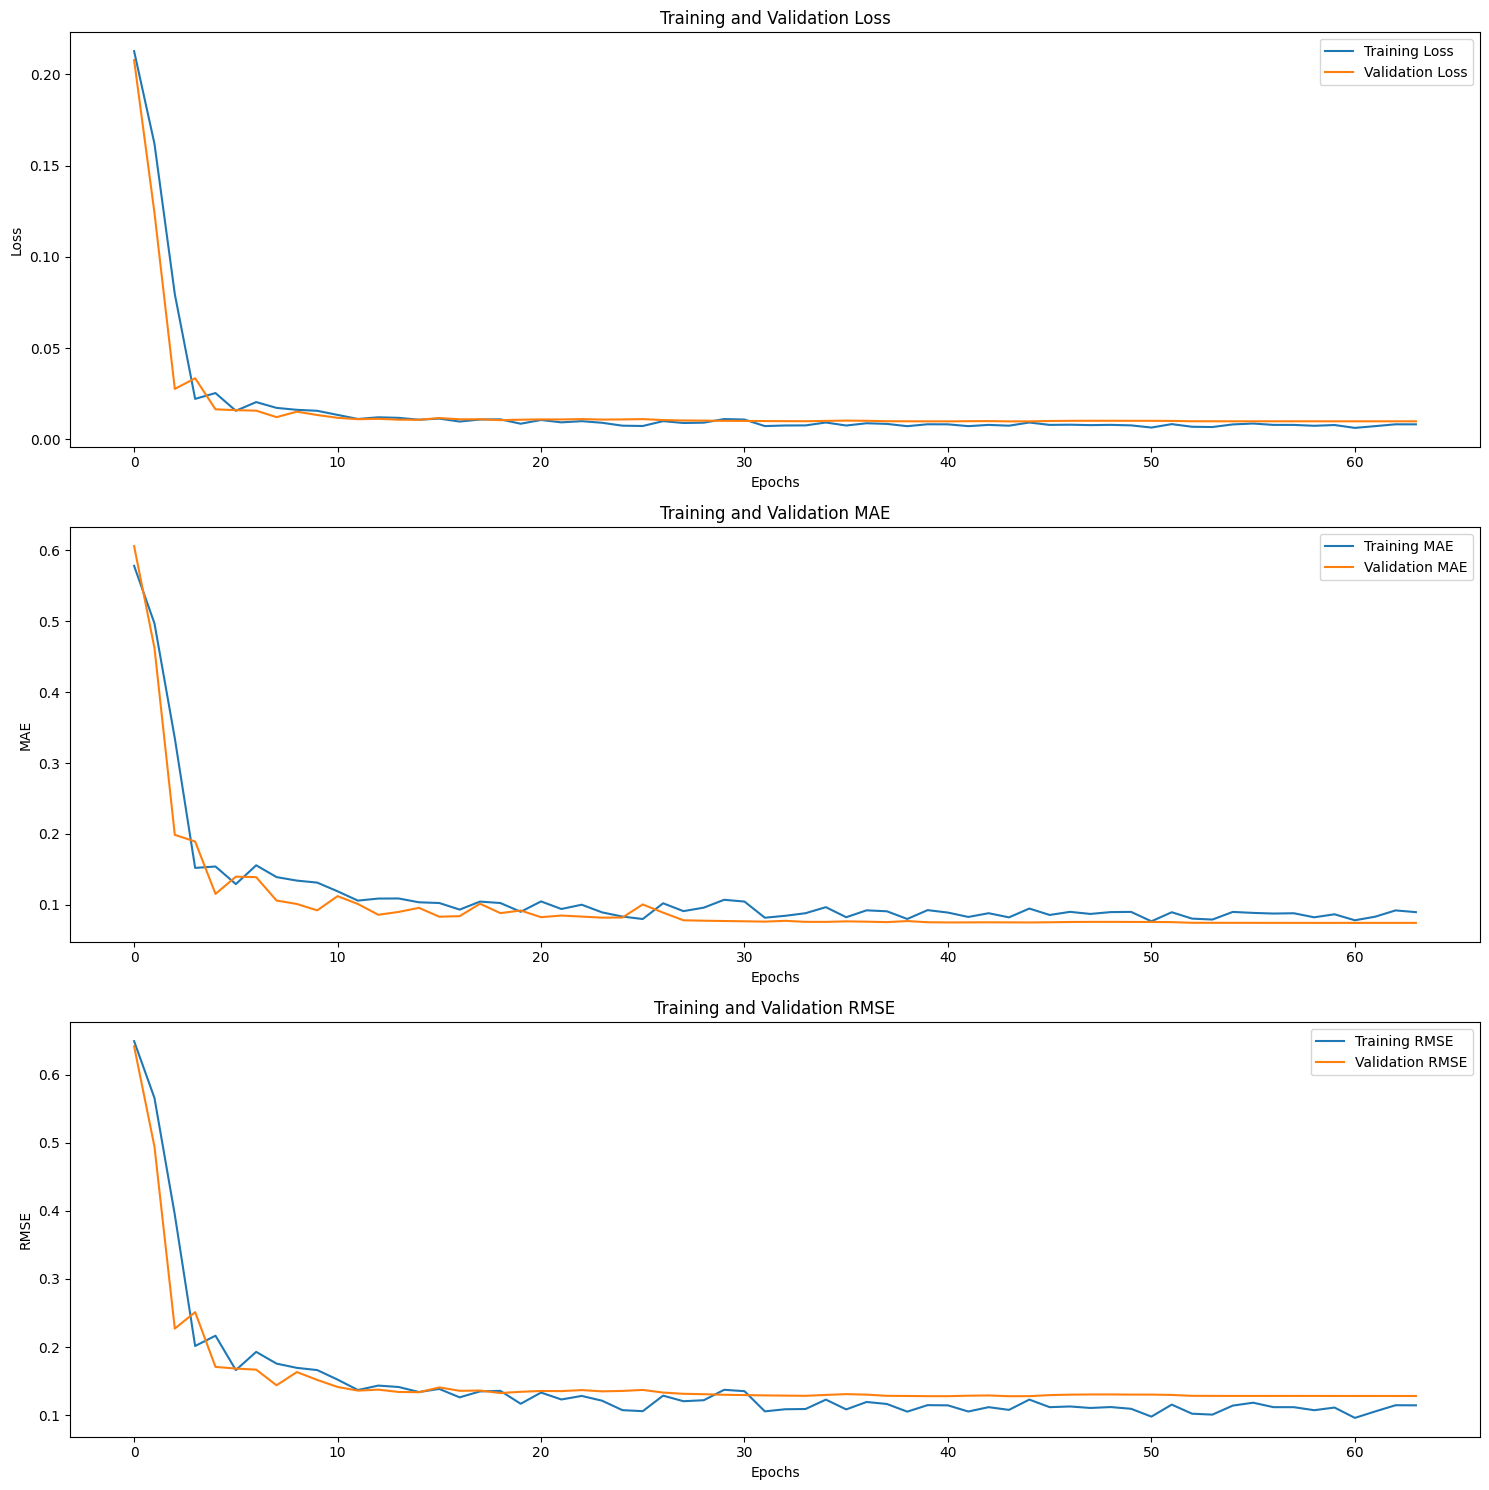

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step

Final Metrics:
R2 Score: 94.81%
MAE: 5.53492
MSE: 47.69865
RMSE: 6.90642
Test Accuracy (based on MAPE): 94.33%


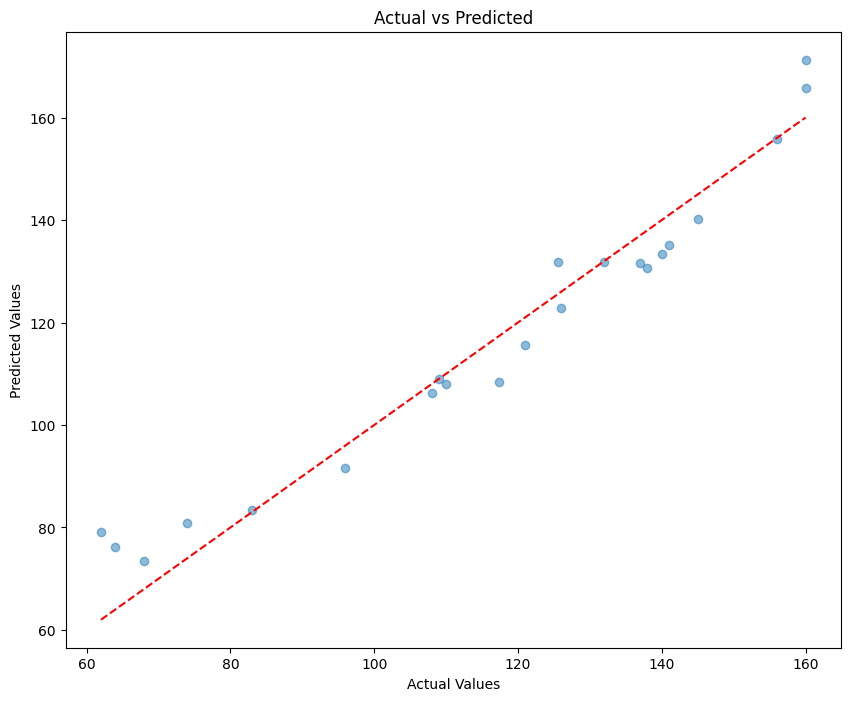

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tsaug import AddNoise, TimeWarp, Drift
import matplotlib.pyplot as plt
import seaborn as sns


# Load and prepare data
file_path = 'New_Data/Final_Dataset.xlsx'
data_01 = pd.read_excel(file_path)
Data = data_01.loc[:, 'ROM_angle':90].values

# Extract Min and Max ROM angle from the original data
rom_angle_min = Data[:, 0].min()
rom_angle_max = Data[:, 0].max()

# Function to constrain ROM angle within original Min and Max range
def constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max):
    augmented_sample[:, 0] = np.clip(augmented_sample[:, 0], rom_angle_min, rom_angle_max)
    return augmented_sample

# Augmentation pipeline
augmenter = (
    TimeWarp(n_speed_change=1, max_speed_ratio=1.2) +
    AddNoise(scale=0.005) +
    Drift(max_drift=0.01, n_drift_points=2)
)

# Generate exactly 20 augmented samples for the entire dataset
augmented_samples = []
for _ in range(20):  # Generate 20 samples
    sampled_rows = Data[np.random.choice(Data.shape[0], size=1, replace=False)]
    augmented_sample = augmenter.augment(sampled_rows)
    augmented_sample = constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max)
    augmented_samples.append(augmented_sample)

# Combine augmented samples into a single array
augmented_samples = np.vstack(augmented_samples)

# Combine original and augmented data
augmented_dataset = np.vstack([Data, augmented_samples])

# Check original and augmented ROM angle distributions
sns.histplot(Data[:, 0], label='Original ROM Angle', kde=True, color='blue')
sns.histplot(augmented_samples[:, 0], label='Augmented ROM Angle', kde=True, color='orange')
plt.legend()
plt.title('Original vs Augmented ROM Angle Distribution')
plt.show()


# Prepare the dataset
X = augmented_dataset[:, 1:]
y = augmented_dataset[:, 0]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Normalize target
y_max, y_min = y.max(), y.min()
y = (y - y_min) / (y_max - y_min)

# Reshape for LSTM input
time_steps = 5
if X_normalized.shape[1] % time_steps != 0:
    n_features = (X_normalized.shape[1] // time_steps) * time_steps
    X_normalized = X_normalized[:, :n_features]
X_reshaped = X_normalized.reshape(X_normalized.shape[0], time_steps, -1)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Model definition
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l2(0.001))
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=Huber(delta=1.0),
    metrics=['mae', RootMeanSquaredError()]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot Training and Validation Metrics
plt.figure(figsize=(15, 15))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot RMSE
plt.subplot(3, 1, 3)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
predictions = model.predict(X_test)
inv_pred = predictions * (y_max - y_min) + y_min
inv_y_test = y_test * (y_max - y_min) + y_min

# Metrics
mape = np.mean(np.abs((inv_y_test - inv_pred.flatten()) / inv_y_test)) * 100
test_accuracy = 100 - mape  # Higher accuracy corresponds to lower error
r2 = r2_score(inv_y_test, inv_pred)
mae = mean_absolute_error(inv_y_test, inv_pred)
mse = mean_squared_error(inv_y_test, inv_pred)
rmse = np.sqrt(mse)

# Results
print("\nFinal Metrics:")
print(f'R2 Score: {r2 * 100:.2f}%')
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'Test Accuracy (based on MAPE): {test_accuracy:.2f}%')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(inv_y_test, inv_pred, alpha=0.5)
plt.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Save the model
# model.save('cnn_lstm_emg_model.h5')


Second Method

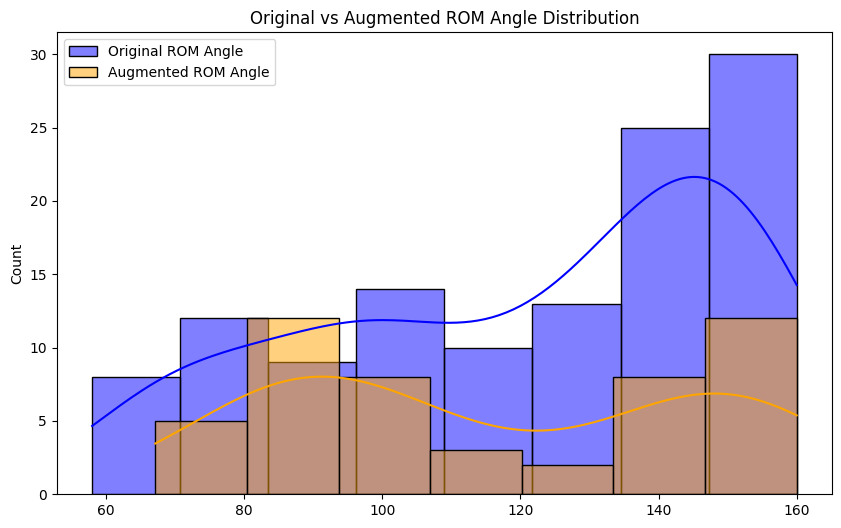

X_train shape: (119, 5, 36)
y_train shape: (119,)
X_val shape: (26, 5, 36)
y_val shape: (26,)


/home/malaka/Projects/Python_Projects/Python_venvs/Image_processing_01/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - loss: 0.2858 - mae: 0.6505 - root_mean_squared_error: 0.7735 - val_loss: 0.1768 - val_mae: 0.5313 - val_root_mean_squared_error: 0.5946 - learning_rate: 0.0010
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1547 - mae: 0.4497 - root_mean_squared_error: 0.5604 - val_loss: 0.1515 - val_mae: 0.4856 - val_root_mean_squared_error: 0.5505 - learning_rate: 0.0010
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0958 - mae: 0.3379 - root_mean_squared_error: 0.4368 - val_loss: 0.1375 - val_mae: 0.4585 - val_root_mean_squared_error: 0.5245 - learning_rate: 0.0010
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0708 - mae: 0.2978 - root_mean_squared_error: 0.3746 - val_loss: 0.1299 - val_mae: 0.4432 - val_root_mean_squared_error: 0.5097 - learning_rate: 0.0010
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0578 - mae: 0.2705 - root_mean_squared_error: 0.3393 - val_loss: 0.1269 - val_mae: 0.4367 

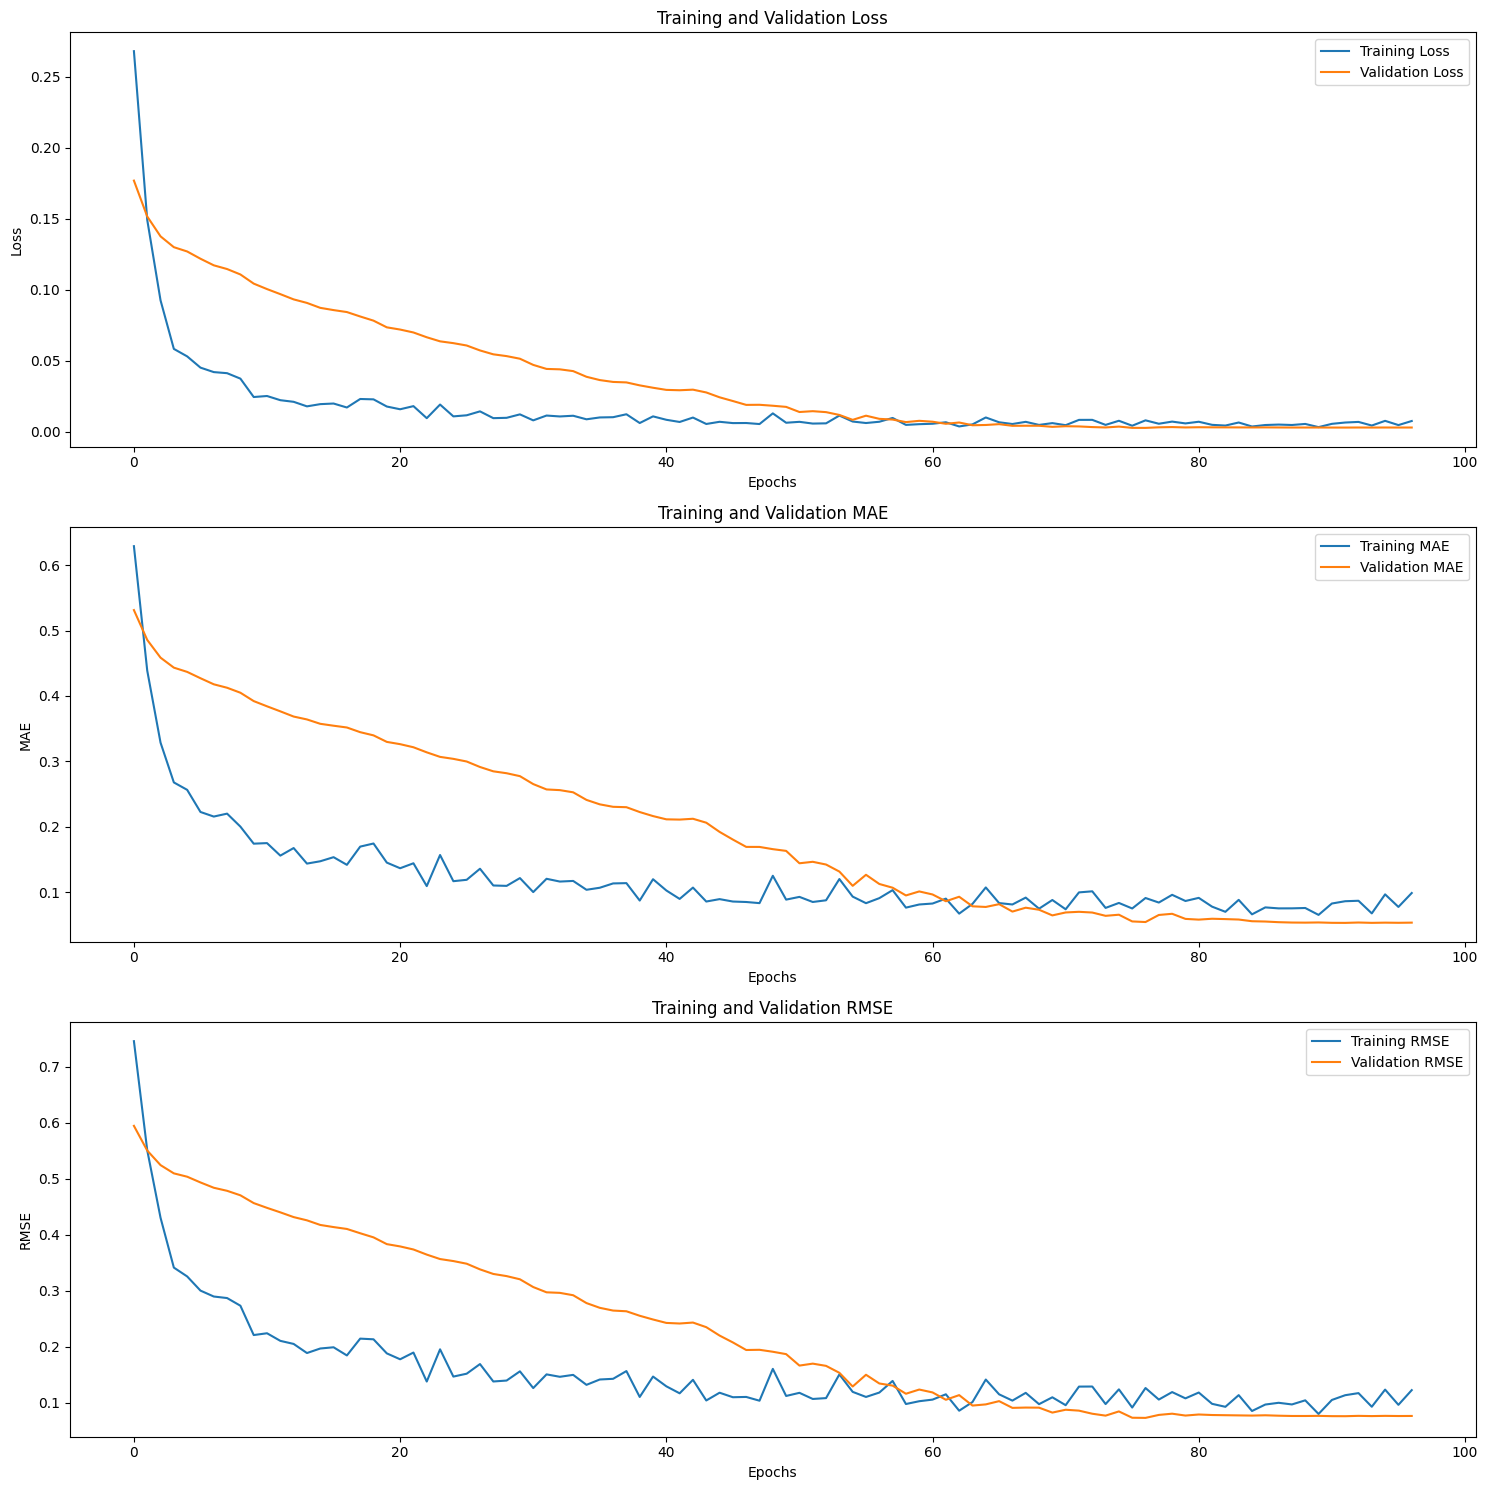

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Final Metrics:
R2 Score: 93.75%
MAE: 5.51185
MSE: 48.53603
RMSE: 6.96678
Test Accuracy (based on MAPE): 95.34%


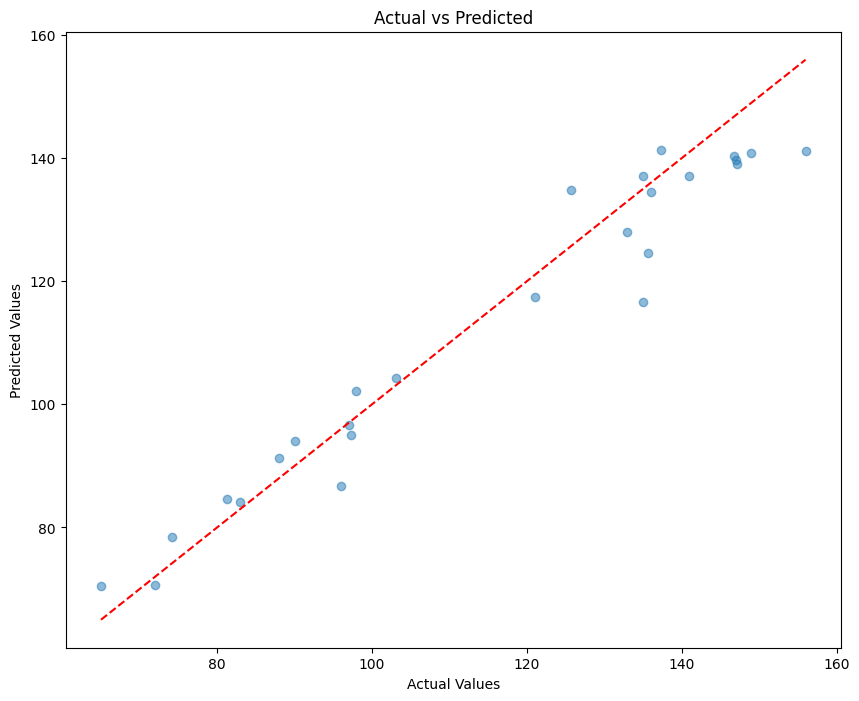

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tsaug import AddNoise, TimeWarp, Drift
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_augment_data(file_path, n_augmented_samples=50):
    """
    Load data and perform augmentation using tsaug
    """
    # Load original data
    data_01 = pd.read_excel(file_path)
    Data = data_01.loc[:, 'ROM_angle':90].values

    # Extract Min and Max ROM angle
    rom_angle_min = Data[:, 0].min()
    rom_angle_max = Data[:, 0].max()

    # Constrain ROM angle function
    def constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max):
        augmented_sample[:, 0] = np.clip(augmented_sample[:, 0], rom_angle_min, rom_angle_max)
        return augmented_sample

    # Enhanced augmentation pipeline
    augmenter = (
        TimeWarp(n_speed_change=1, max_speed_ratio=1.2) +
        AddNoise(scale=0.005) +
        Drift(max_drift=0.01, n_drift_points=2)
    )

    # Generate augmented samples
    augmented_samples = []
    for _ in range(n_augmented_samples):
        sampled_rows = Data[np.random.choice(Data.shape[0], size=1, replace=False)]
        augmented_sample = augmenter.augment(sampled_rows)
        augmented_sample = constrain_rom_angle(augmented_sample, rom_angle_min, rom_angle_max)
        augmented_samples.append(augmented_sample)

    # Combine augmented samples
    augmented_samples = np.vstack(augmented_samples)
    augmented_dataset = np.vstack([Data, augmented_samples])

    return augmented_dataset, Data, augmented_samples

def prepare_data(augmented_dataset, time_steps=5):
    """
    Prepare and split the dataset
    """
    X = augmented_dataset[:, 1:]
    y = augmented_dataset[:, 0]

    # Normalize features
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)

    # Normalize target
    y_max, y_min = y.max(), y.min()
    y = (y - y_min) / (y_max - y_min)

    # Reshape for LSTM input
    if X_normalized.shape[1] % time_steps != 0:
        n_features = (X_normalized.shape[1] // time_steps) * time_steps
        X_normalized = X_normalized[:, :n_features]
    X_reshaped = X_normalized.reshape(X_normalized.shape[0], time_steps, -1)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Ensure y is 1D
    y_train = y_train.reshape(-1)
    y_val = y_val.reshape(-1)
    y_test = y_test.reshape(-1)

    return X_train, X_val, X_test, y_train, y_val, y_test, y_min, y_max

def build_model(input_shape):
    """
    Build the CNN-LSTM model with improved architecture
    """
    model = Sequential()

    # CNN layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    return model

def train_model(file_path):
    """
    Main training function
    """
    # Load and augment data
    augmented_dataset, original_data, augmented_samples = load_and_augment_data(file_path)

    # Plot original vs augmented distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(original_data[:, 0], label='Original ROM Angle', kde=True, color='blue', alpha=0.5)
    sns.histplot(augmented_samples[:, 0], label='Augmented ROM Angle', kde=True, color='orange', alpha=0.5)
    plt.legend()
    plt.title('Original vs Augmented ROM Angle Distribution')
    plt.show()

    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test, y_min, y_max = prepare_data(augmented_dataset)

    # Debugging shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")

    # Build model
    model = build_model((X_train.shape[1], X_train.shape[2]))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(delta=1.0),
        metrics=['mae', RootMeanSquaredError()]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(15, 15))

    # Plot Loss
    plt.subplot(3, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(3, 1, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Plot RMSE
    plt.subplot(3, 1, 3)
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate model
    predictions = model.predict(X_test)
    inv_pred = predictions * (y_max - y_min) + y_min
    inv_y_test = y_test * (y_max - y_min) + y_min

    # Calculate metrics
    mape = np.mean(np.abs((inv_y_test - inv_pred.flatten()) / inv_y_test)) * 100
    test_accuracy = 100 - mape
    r2 = r2_score(inv_y_test, inv_pred)
    mae = mean_absolute_error(inv_y_test, inv_pred)
    mse = mean_squared_error(inv_y_test, inv_pred)
    rmse = np.sqrt(mse)

    # Print metrics
    print("\nFinal Metrics:")
    print(f'R2 Score: {r2 * 100:.2f}%')
    print(f'MAE: {mae:.5f}')
    print(f'MSE: {mse:.5f}')
    print(f'RMSE: {rmse:.5f}')
    print(f'Test Accuracy (based on MAPE): {test_accuracy:.2f}%')

    # Plot predictions
    plt.figure(figsize=(10, 8))
    plt.scatter(inv_y_test, inv_pred, alpha=0.5)
    plt.plot([inv_y_test.min(), inv_y_test.max()], [inv_y_test.min(), inv_y_test.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    return model

if __name__ == "__main__":
    file_path = "New_Data/Final_Dataset.xlsx"  # Replace with your data path
    model = train_model(file_path)


In [ ]:
! pip install openpyxl --proxy http://192.168.158.243:44355


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 126.4 kB/s eta 0:00:0000:0100:01
